In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import utils
import copy, time
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'STIXGeneral'  # Closely matches Computer Modern
plt.rcParams['mathtext.fontset'] = 'stix'    # Use STIX for math

### Let's test things to make sure it all looks sensible

In [2]:
# Example TOAs in MJD (Modified Julian Date)
toas = jnp.linspace(58000.0, 61000.0, 100) * 86400.

In [3]:
# Instantiate the pulsar with those TOAs and sky position
psr = utils.Pulsar(name="J1234+5678", 
             ra=jnp.radians(123.4567), dec=jnp.radians(56.7890), 
             toas=toas)

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:41: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.toaerrs = jnp.array(toaerrs)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:50: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.pdist = jnp.array(pdist)


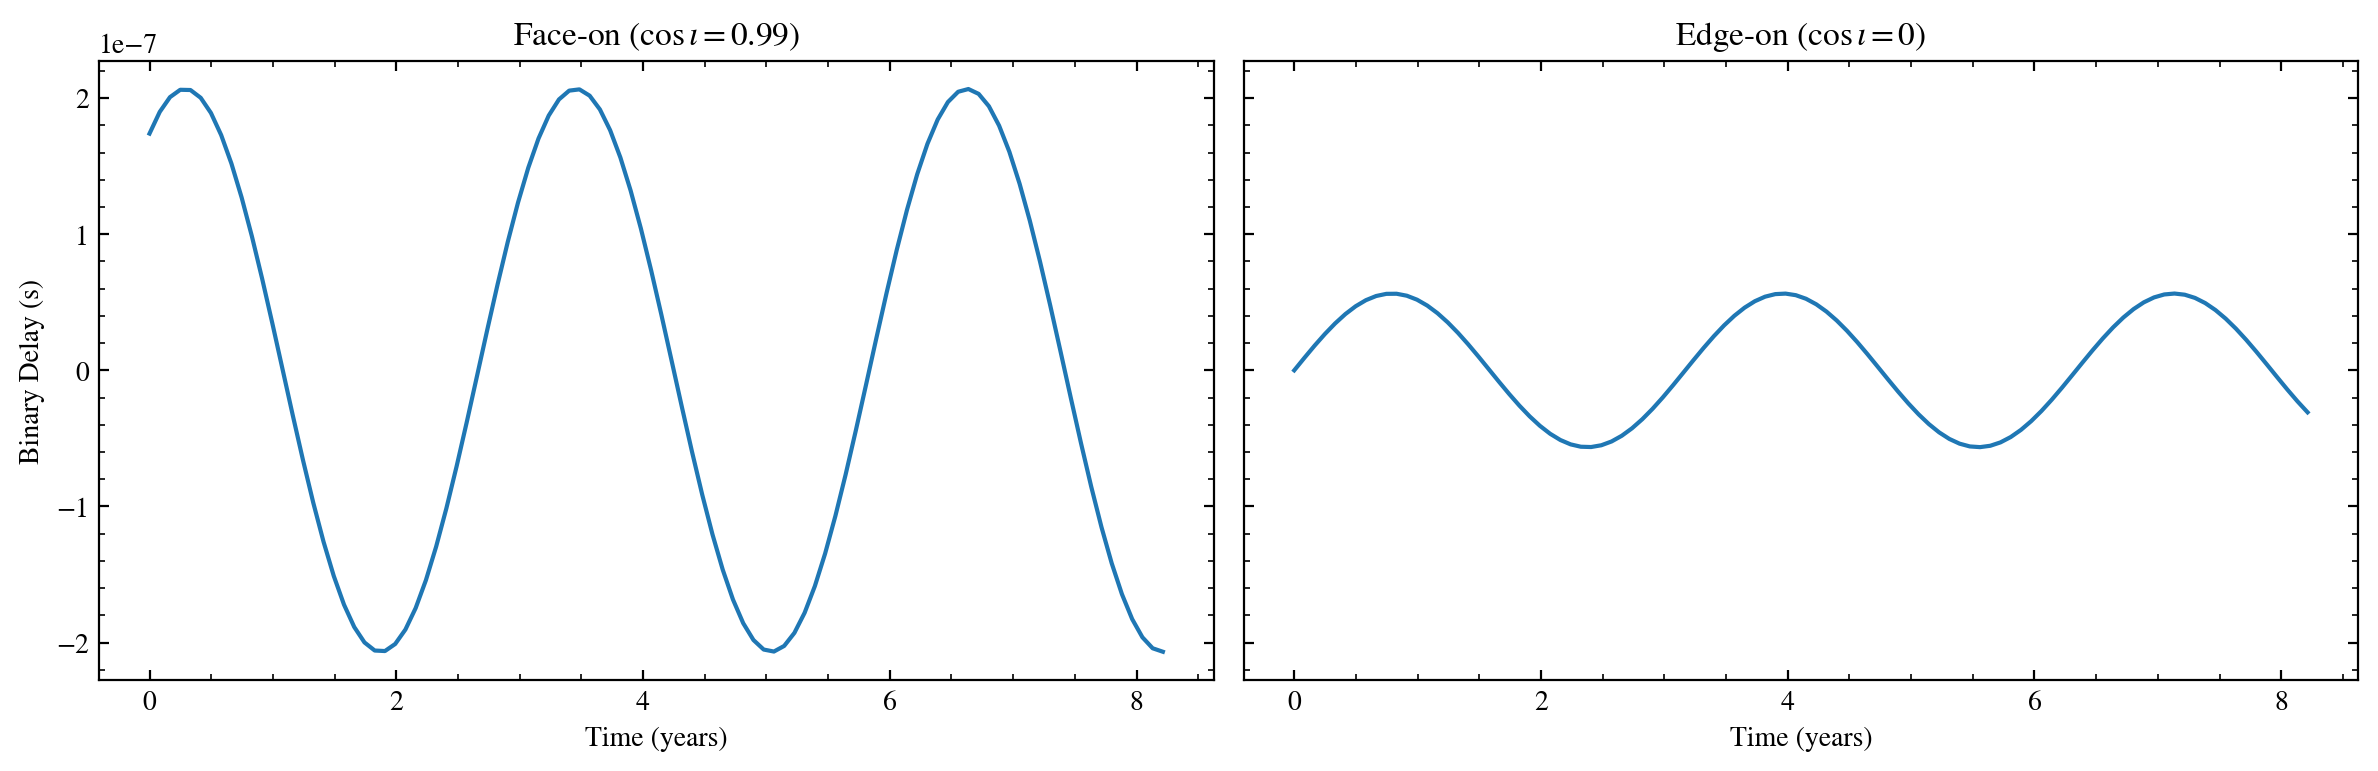

In [4]:
cw_signal = utils.CW_Signal(psr=psr, tref=psr.toas[0], evolve=False)

pars = []
# equator, face-on
pars.append(dict(cw_costheta=0.0, cw_phi=0., cw_cosinc=0.99, cw_log10_Mc=9.5, cw_log10_fgw=-8., 
                 cw_log10_dist=2., cw_phase0=0., cw_psi=0.,))
# equator, edge-on
pars.append(dict(cw_costheta=0.0, cw_phi=0., cw_cosinc=0., cw_log10_Mc=9.5, cw_log10_fgw=-8., 
                 cw_log10_dist=2., cw_phase0=0., cw_psi=0.,))

# Compute delays for both parameter sets
delays = []
for par in pars:
    delay = cw_signal.get_delay(pars=par)
    delays.append(delay)

# Prepare side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
times = (psr.toas - psr.toas[0]) / 86400. / 365.25

labels = ['Face-on ($\cos\iota=0.99$)', 'Edge-on ($\cos\iota=0$)']
for i, ax in enumerate(axes):
    ax.plot(times, delays[i], linestyle='-', marker=None)
    ax.set_title(labels[i])
    ax.set_xlabel('Time (years)')
    if i == 0:
        ax.set_ylabel('Binary Delay (s)')
    #ax.grid(True)
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', tick2On=True)

plt.tight_layout()
plt.show()

Looks good!

#### Now how about function derivatives with Jax? 

In [15]:
pars = dict(cw_costheta=0.001, cw_phi=0.001, cw_cosinc=0.99, cw_log10_Mc=9.5, cw_log10_fgw=-8., 
            cw_log10_dist=2., cw_phase0=0.001, cw_psi=0.001,)

In [16]:
# get the list of your parameter‐names
param_keys = list(pars.keys())

# cast your integer param_values → float
param_vec = jnp.array(list(pars.values()))

# define a function from flat vec → delays
def delay_vec(vec):
    # rebuild the dict and compute delays
    p = dict(zip(param_keys, vec))
    return cw_signal.get_delay(pars=p)

# compute full Jacobian: shape (n_params, n_toas)
jac = jax.jacrev(delay_vec)(param_vec)

In [17]:
print(jac.shape)

(100, 8)


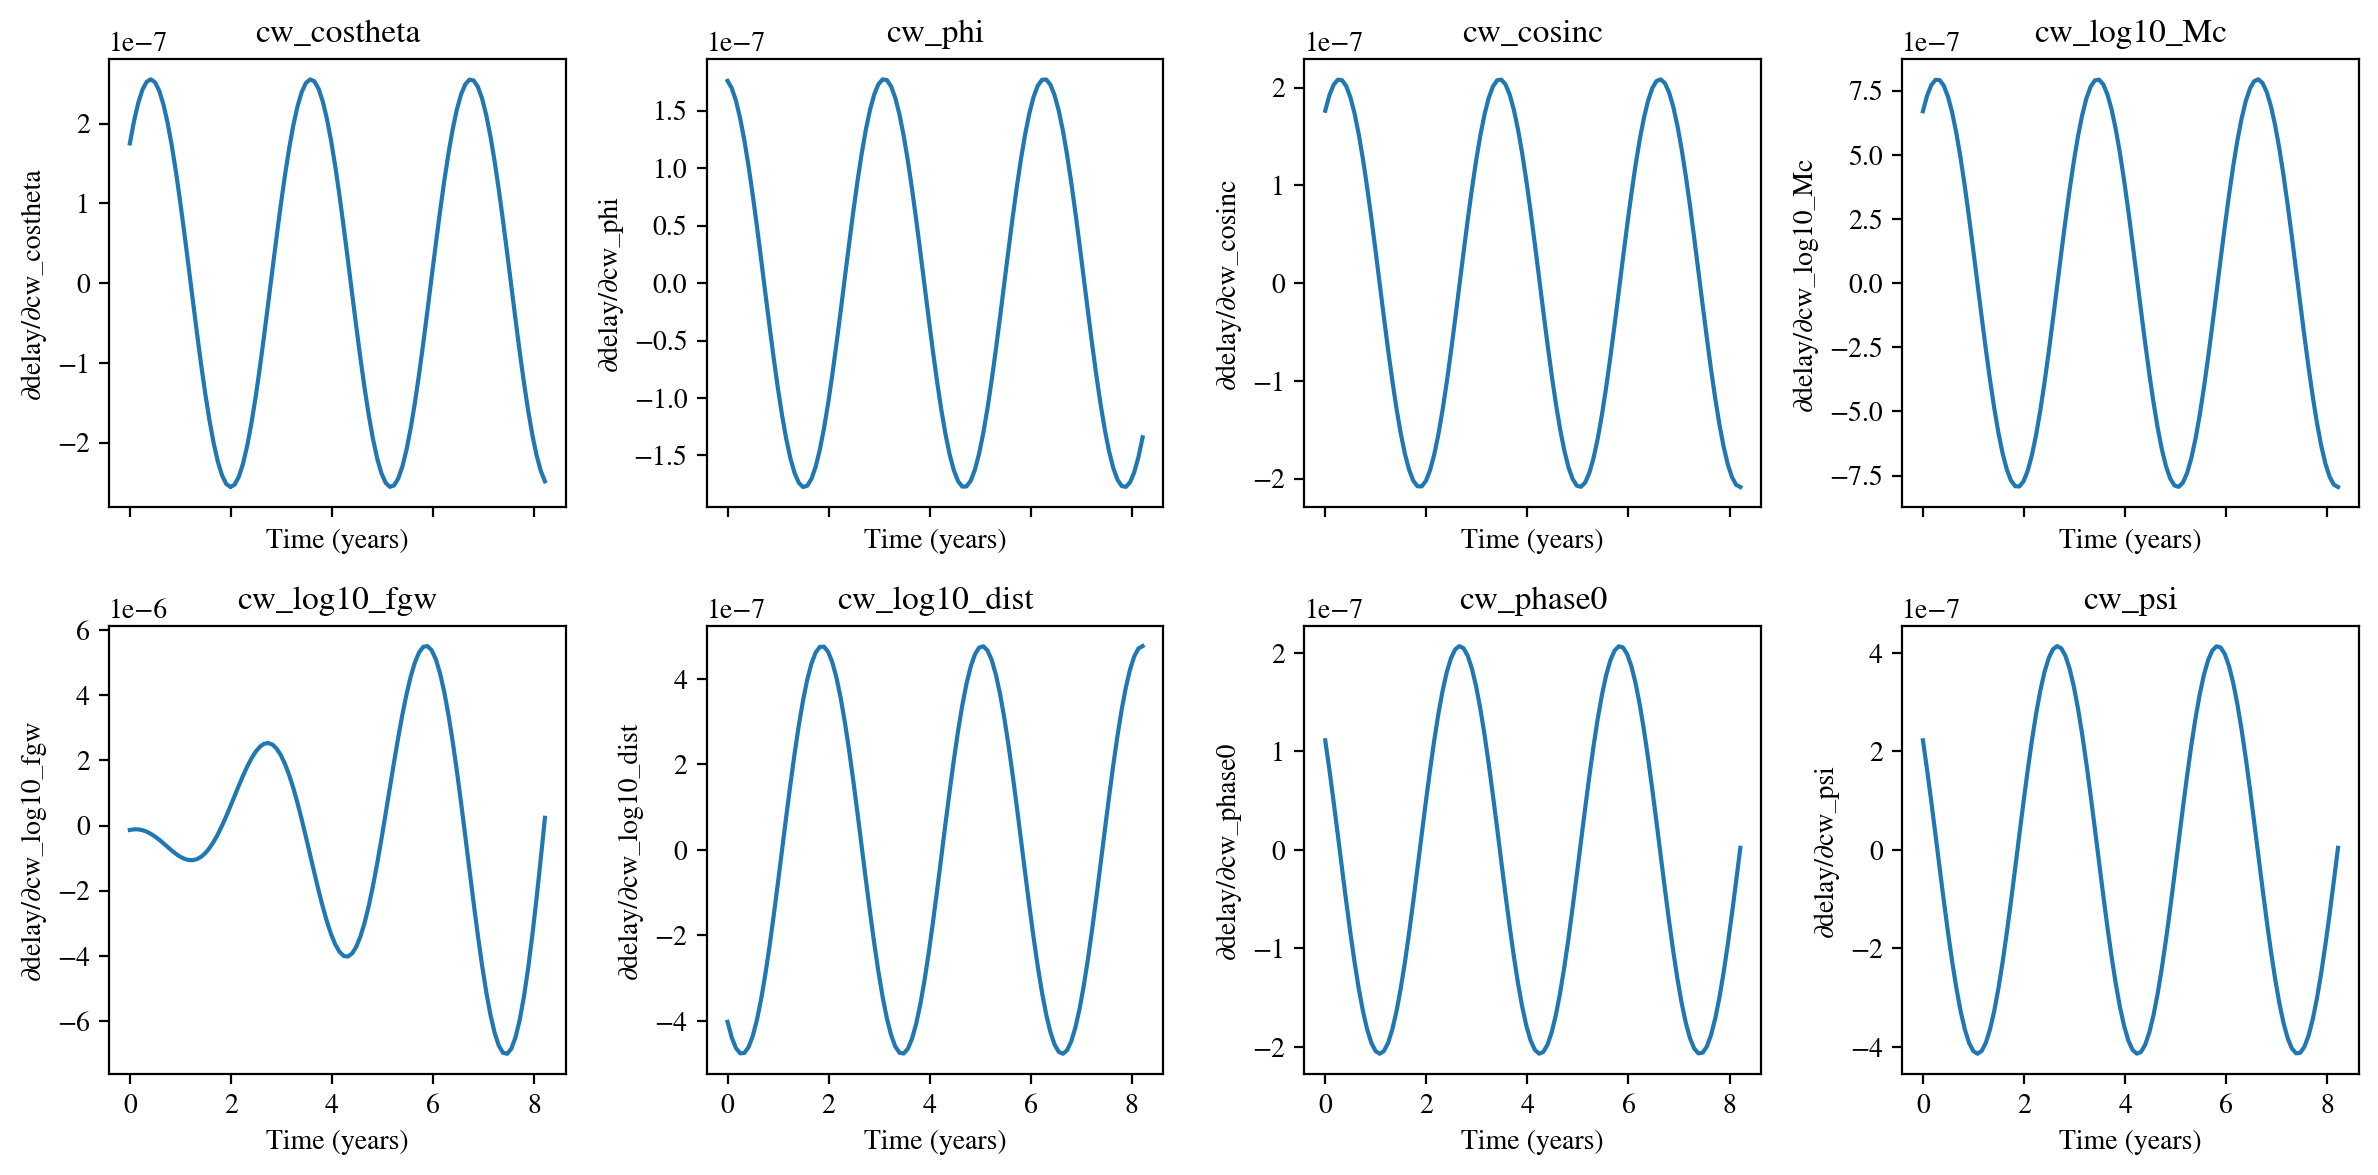

In [18]:
# Plot the partial derivatives in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=False)
axes = axes.flatten()

for i, key in enumerate(param_keys):
    axes[i].plot(times, jac[:, i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Time (years)')
    axes[i].set_ylabel(f'∂delay/∂{key}')

plt.tight_layout()
plt.show()

Partial derivative of signal waveform with respect to $\log_{10}d_L$ should be $-\ln(10)$ times the waveform. Let's check.

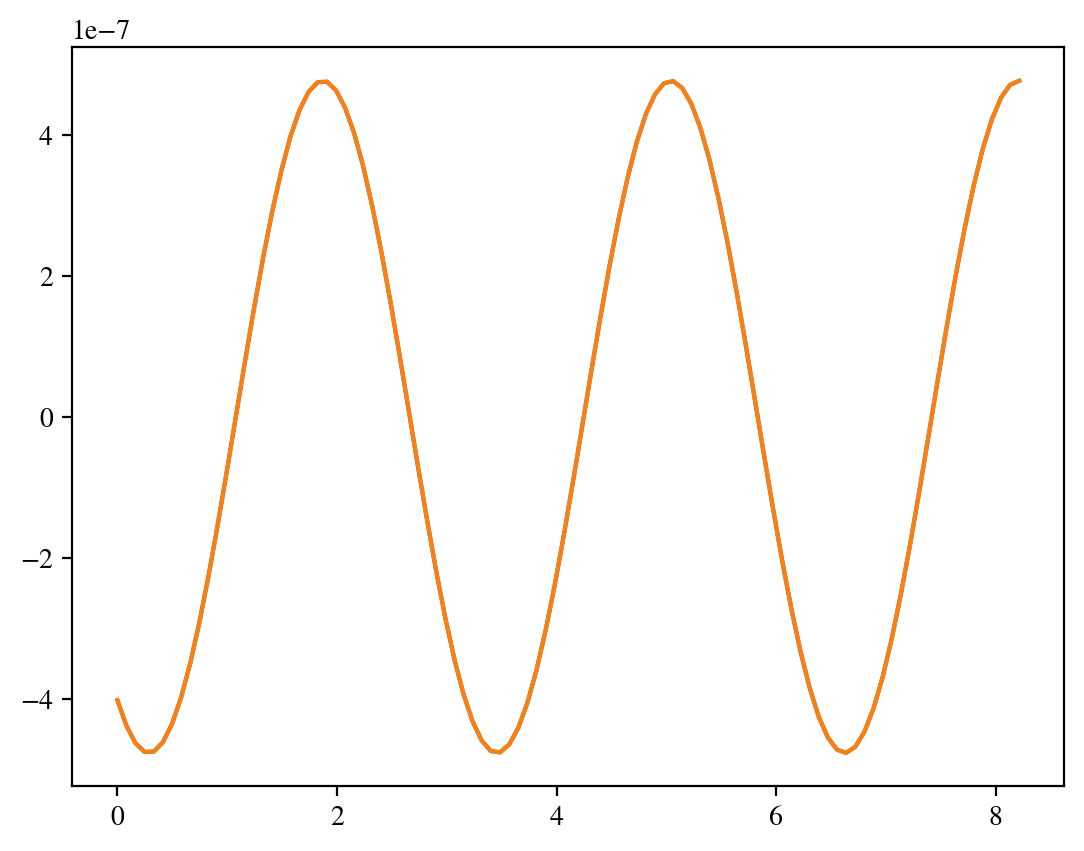

In [19]:
plt.plot(times, jac[:, 5]);
plt.plot(times, -jnp.log(10.0) * cw_signal.get_delay(pars=pars))
plt.show()

### Testing new pulsar-term code (06/22/2025)

In [5]:
# Instantiate the pulsar with those TOAs and sky position
psr_new = utils.Pulsar(name="J1234+5678", 
             ra=jnp.radians(123.4567), dec=jnp.radians(56.7890), 
             toas=toas, pdist=[5.0,1e-3])

In [6]:
psr_new.pdist

Array([5.e+00, 1.e-03], dtype=float64)

In [7]:
cw_signal_new = utils.CW_Signal(psr=psr_new, tref=psr_new.toas[0], evolve=True)

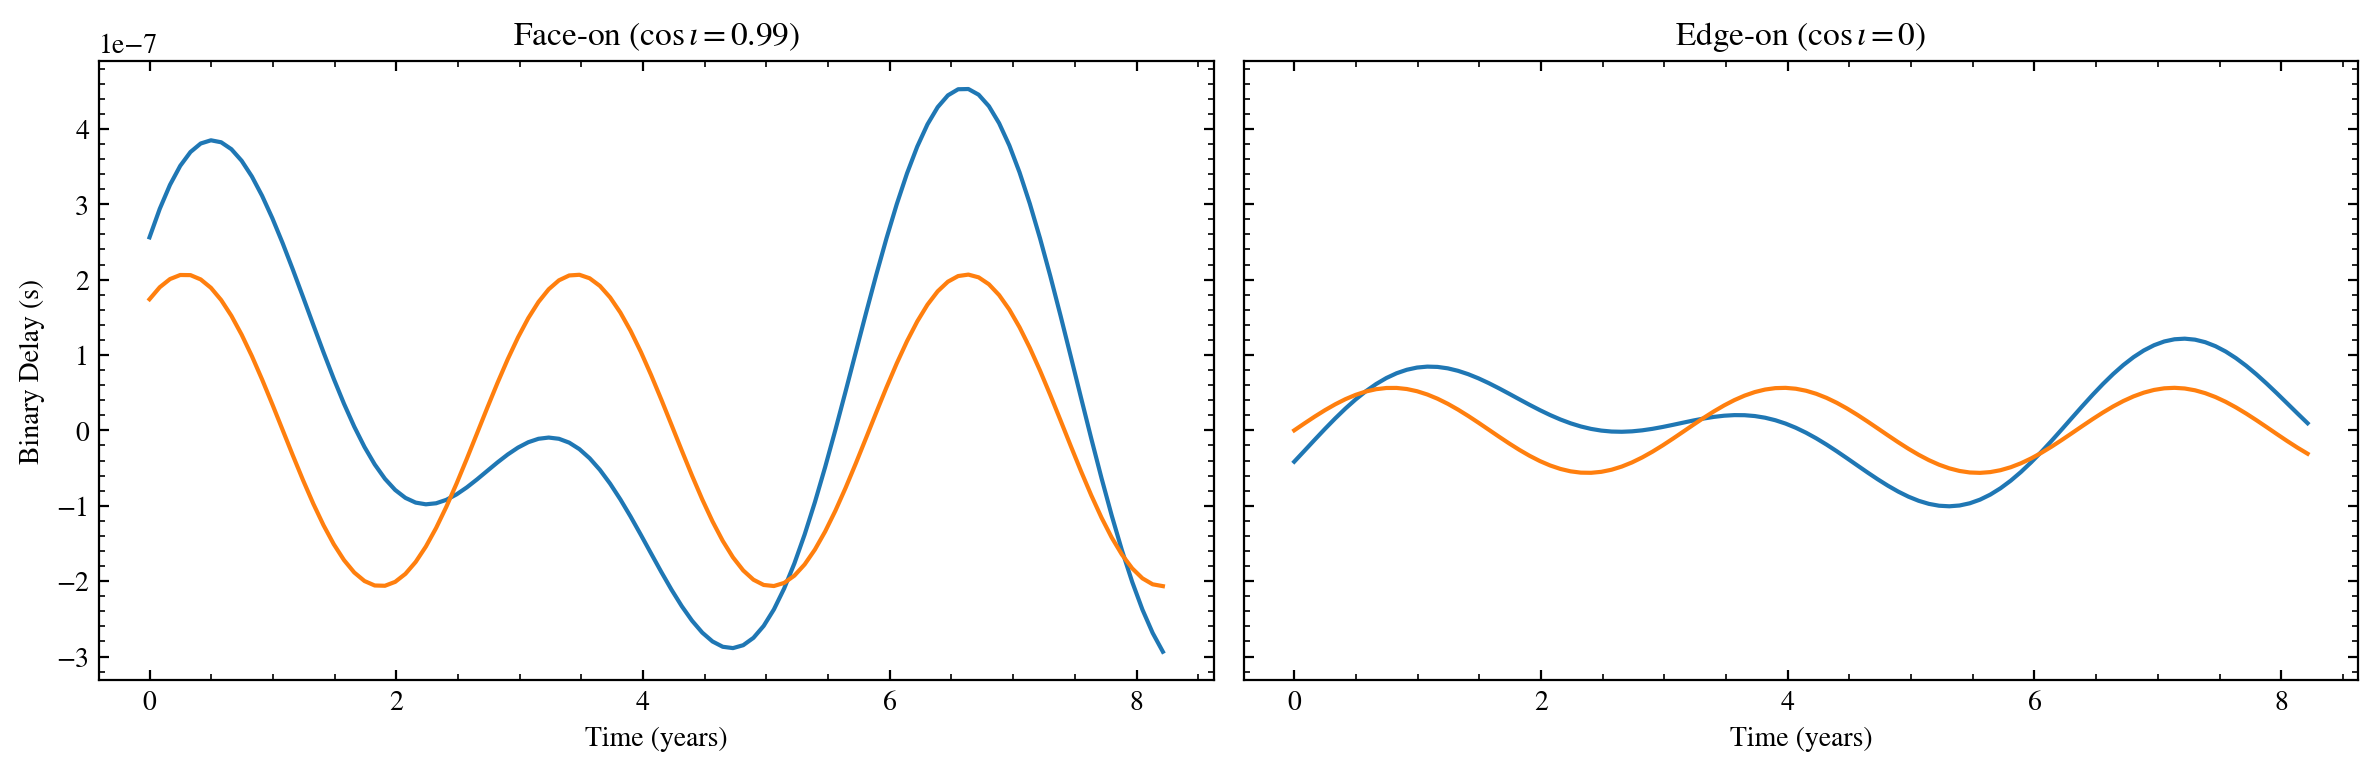

In [8]:
pars = []
# equator, face-on
pars.append(dict(cw_costheta=0.0, cw_phi=0., cw_cosinc=0.99, cw_log10_Mc=9.5, cw_log10_fgw=-8., 
                 cw_log10_dist=2., cw_phase0=0., cw_psi=0., p_dist=0.))
# equator, edge-on
pars.append(dict(cw_costheta=0.0, cw_phi=0., cw_cosinc=0., cw_log10_Mc=9.5, cw_log10_fgw=-8., 
                 cw_log10_dist=2., cw_phase0=0., cw_psi=0., p_dist=0.))

# Compute delays for both parameter sets
delays_full = []
delays_et = []
for par in pars:
    delay_full = cw_signal_new.get_fulldelay(pars=par)
    delays_full.append(delay_full)
    ##
    delay_et = cw_signal_new.get_delay(pars=par)
    delays_et.append(delay_et)

# Prepare side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
times = (psr.toas - psr.toas[0]) / 86400. / 365.25

labels = ['Face-on ($\cos\iota=0.99$)', 'Edge-on ($\cos\iota=0$)']
for i, ax in enumerate(axes):
    ax.plot(times, delays_full[i], linestyle='-', marker=None)
    ax.plot(times, delays_et[i], linestyle='-', marker=None)
    ax.set_title(labels[i])
    ax.set_xlabel('Time (years)')
    if i == 0:
        ax.set_ylabel('Binary Delay (s)')
    #ax.grid(True)
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', tick2On=True)

plt.tight_layout()
plt.show()

#### Now test jax derivatives again

In [9]:
pars = dict(cw_costheta=0.001, cw_phi=0.001, cw_cosinc=0.99, cw_log10_Mc=9.5, cw_log10_fgw=-8., 
            cw_log10_dist=2., cw_phase0=0.001, cw_psi=0.001, p_dist=0.001)

In [10]:
# get the list of your parameter‐names
param_keys = list(pars.keys())

# cast your integer param_values → float
param_vec = jnp.array(list(pars.values()))

# define a function from flat vec → delays
def delay_vec(vec):
    # rebuild the dict and compute delays
    p = dict(zip(param_keys, vec))
    return cw_signal_new.get_fulldelay(pars=p)

# compute full Jacobian: shape (n_params, n_toas)
jac = jax.jacrev(delay_vec)(param_vec)

In [11]:
print(jac.shape)

(100, 9)


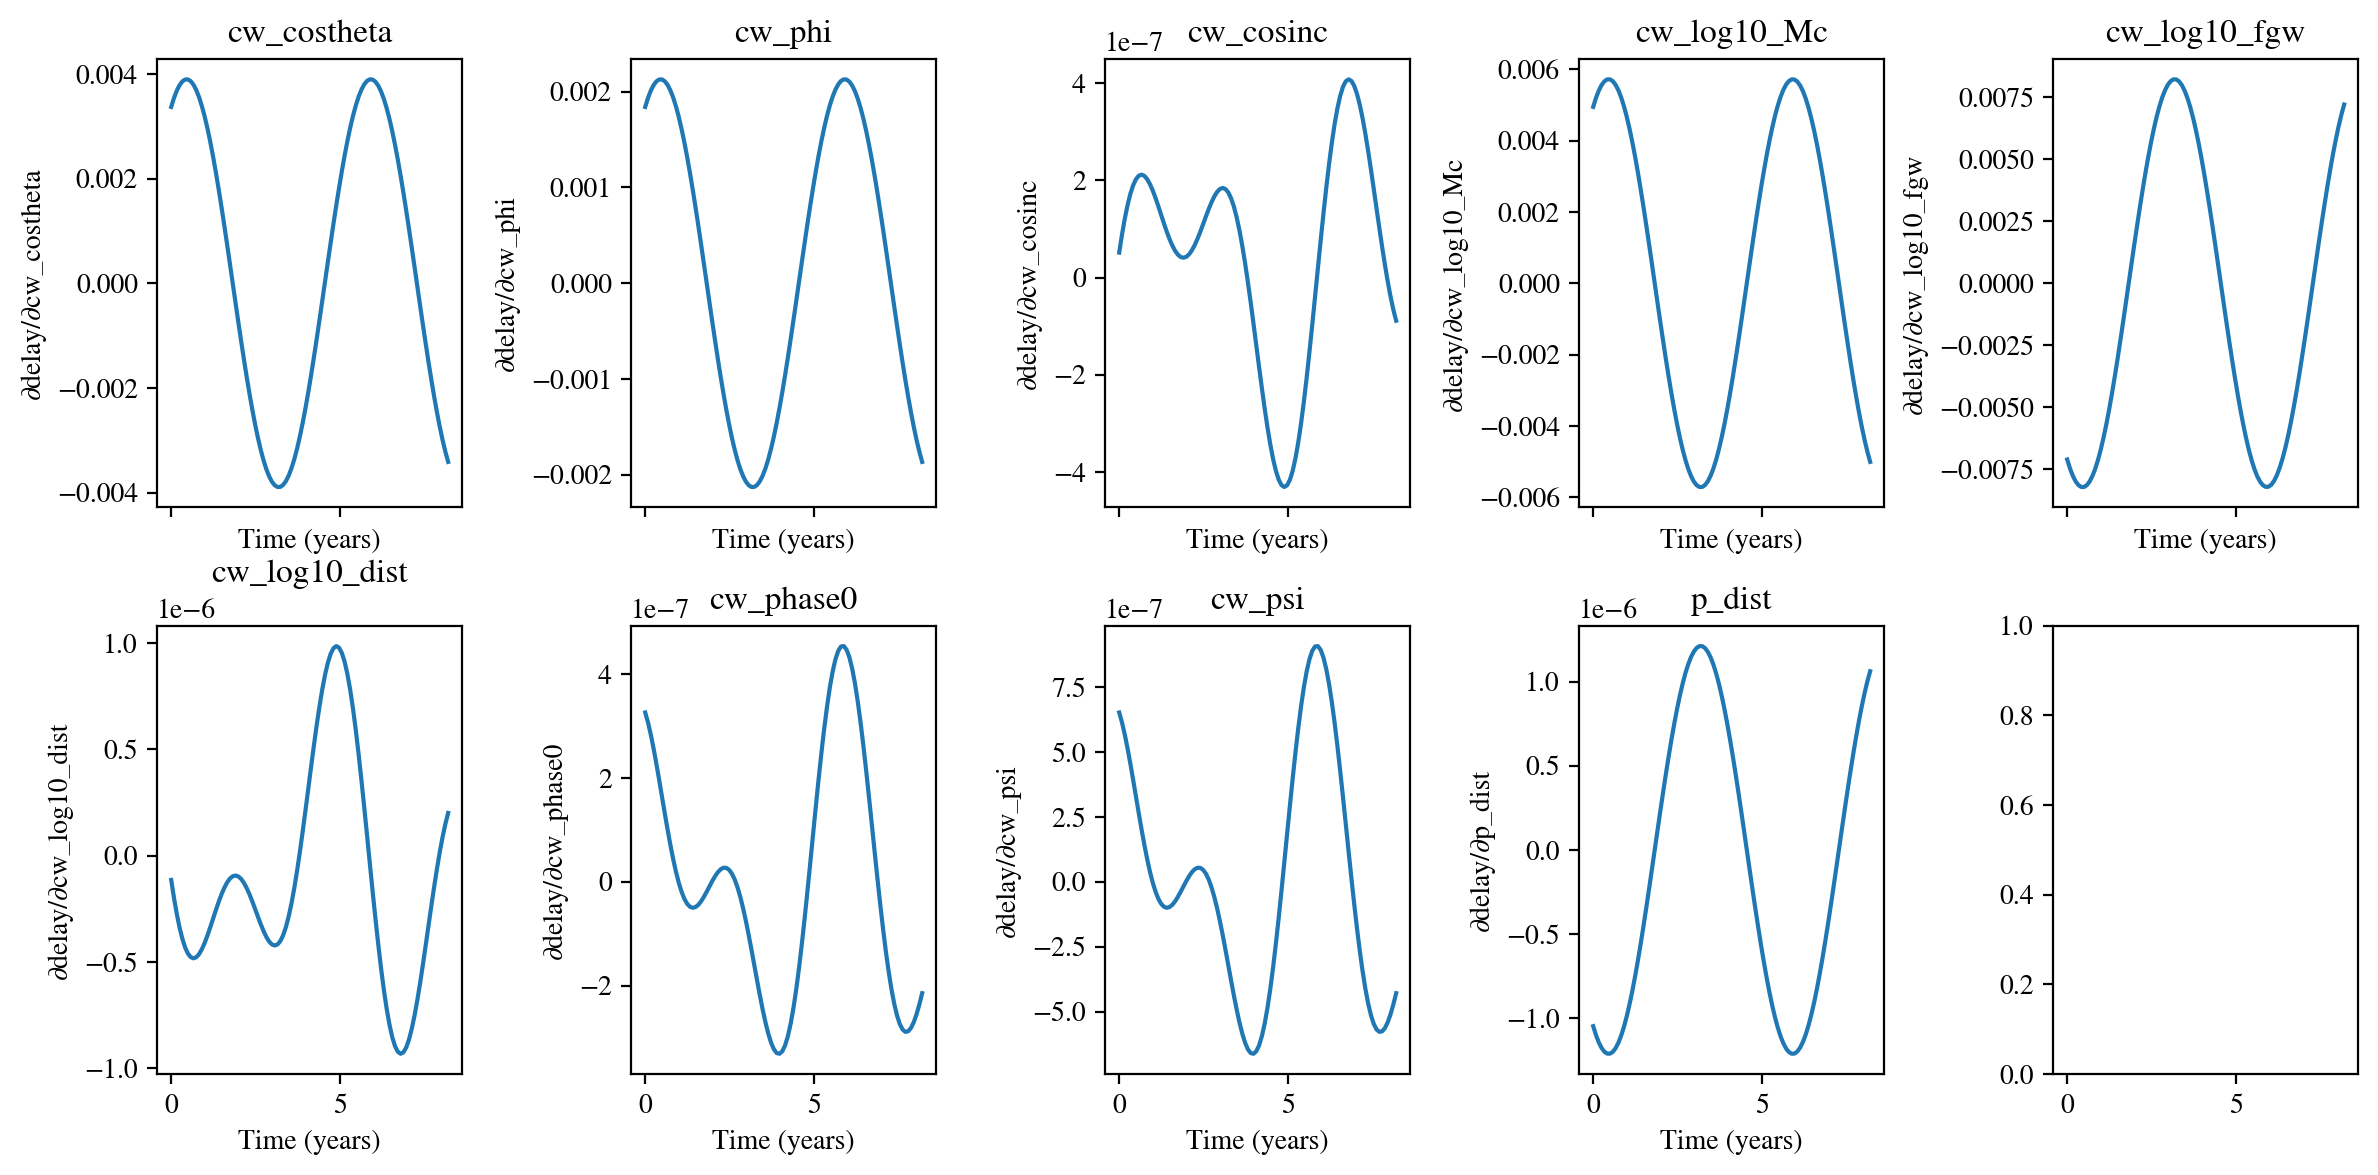

In [13]:
# Plot the partial derivatives in a 2x4 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharex=True, sharey=False)
axes = axes.flatten()

for i, key in enumerate(param_keys):
    axes[i].plot(times, jac[:, i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Time (years)')
    axes[i].set_ylabel(f'∂delay/∂{key}')

plt.tight_layout()
plt.show()